In [1]:
#в датасетах есть категории которые можно упростить с помощью ранжировки от 1 до N, где N это число которое следует указать ниже
rang_group = 20
#если хотим прогнать все модели и найти лучшие параметры,то указать True
check_all_models = True

In [2]:
import itertools
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.columns = train_data.columns.str.lower()
train_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.columns = test_data.columns.str.lower()
test_data.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<Axes: xlabel='survived', ylabel='count'>

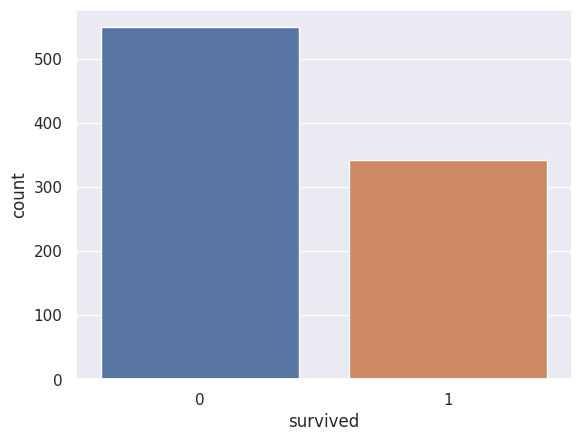

In [7]:
#посмотрим теперь на общую выживаемость
sns.countplot(data=train_data, x='survived')

<Axes: xlabel='sex', ylabel='count'>

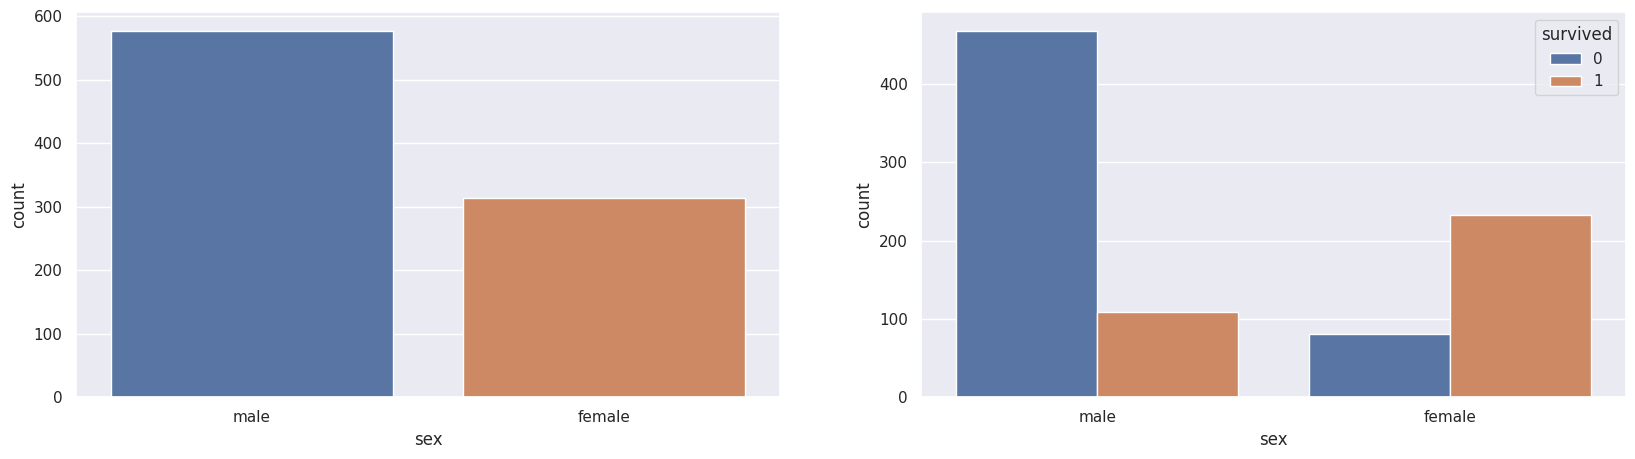

In [8]:
#на графиках ниже показана выживаемость по половому признаку
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(ax=axes[0], data=train_data,x='sex')
sns.countplot(ax=axes[1],data=train_data,x='sex',hue='survived')

<Axes: xlabel='embarked', ylabel='survived'>

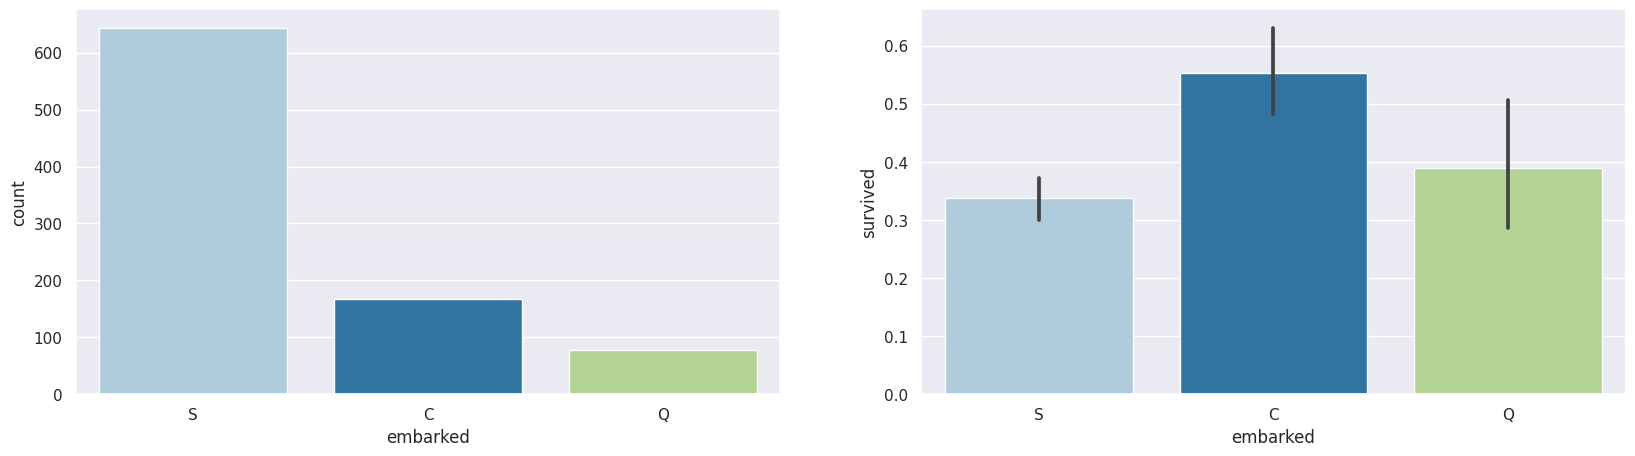

In [9]:
# теперь проверим выживаемость по месту посадки
# слева сколько село в каждом из портов
# справа выживаемость по посадкам
sns.set_palette('Paired')
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(ax=axes[0], data=train_data,x='embarked')
sns.barplot(ax=axes[1],data=train_data, x= 'embarked', y='survived')

<Axes: xlabel='embarked', ylabel='survived'>

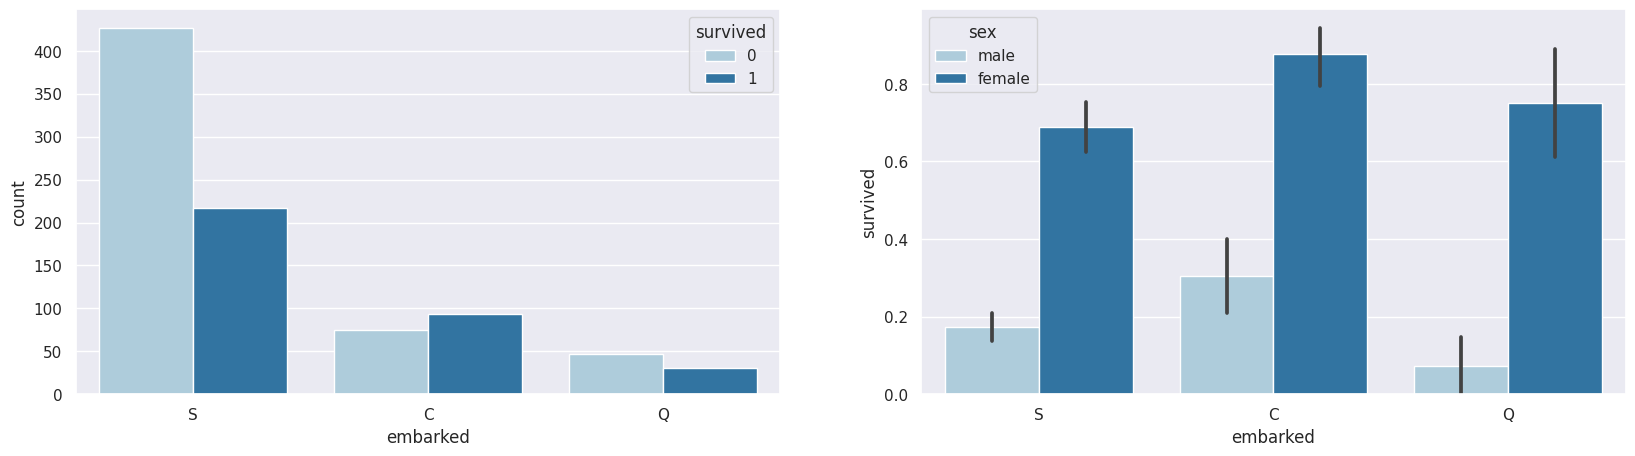

In [10]:
# теперь совместим пол пассажиров и порты
sns.set_palette('Paired')
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(ax=axes[0], data=train_data,x='embarked', hue='survived')
sns.barplot(ax=axes[1],data=train_data, x= 'embarked', y='survived', hue='sex')

<Axes: xlabel='sex', ylabel='survived'>

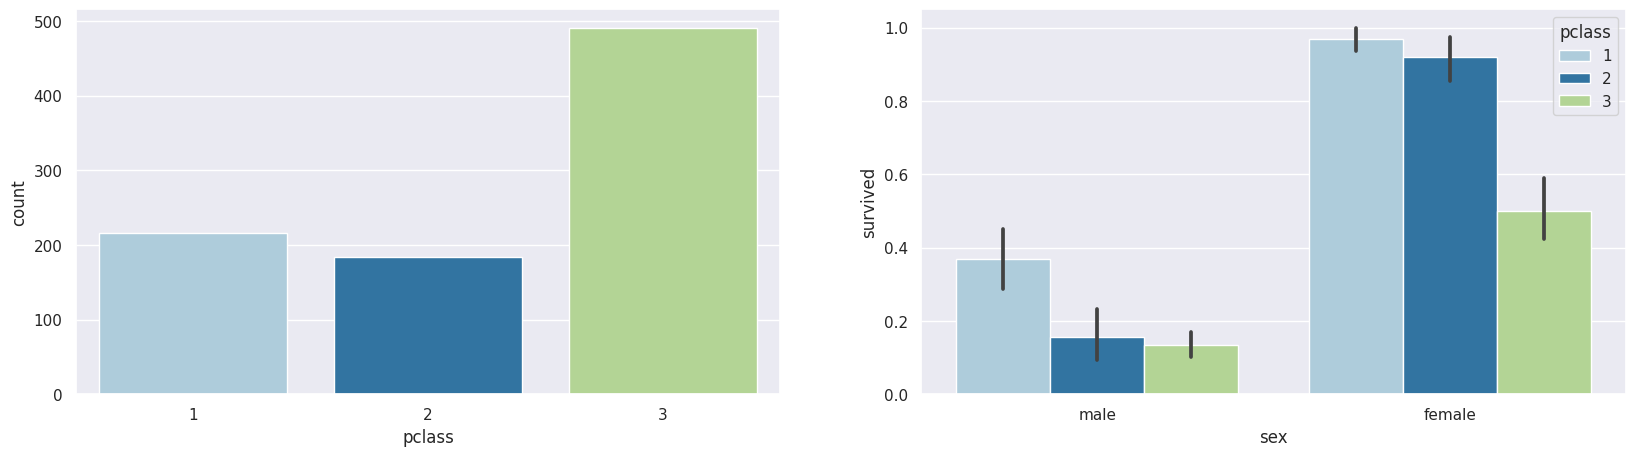

In [11]:
# проверим выживаемость по классу
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(ax=axes[0], data=train_data,x='pclass')
sns.barplot(ax=axes[1], data=train_data,x='sex',y='survived', hue="pclass")

In [12]:
# здесь объединим датасеты для упрощения процесса предобработки данных сразу везде
all_data=pd.concat([train_data,test_data], ignore_index=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  1309 non-null   int64  
 1   survived     891 non-null    float64
 2   pclass       1309 non-null   int64  
 3   name         1309 non-null   object 
 4   sex          1309 non-null   object 
 5   age          1046 non-null   float64
 6   sibsp        1309 non-null   int64  
 7   parch        1309 non-null   int64  
 8   ticket       1309 non-null   object 
 9   fare         1308 non-null   float64
 10  cabin        295 non-null    object 
 11  embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [13]:
#проверим гипотезу по номерам билетов - т.е. чем раньше номер билета тем дальше сажали пассажира, тем самым уменьшая шанс на выживание или наоборот
all_data['ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [14]:
# оставим только циферные значения
# Пример извлечения и преобразования цифр
def extract_digits(ticket):
    digits = re.findall(r'\d+', ticket)
    return int(''.join(digits)) if digits else np.nan

# Извлечение цифр и конвертация в int
all_data['digit_ticket'] = all_data['ticket'].apply(extract_digits)

# Отключаем научную нотацию
np.set_printoptions(suppress=True)

# Проверка уникальных значений
all_data['digit_ticket'].unique()

array([  521171.,    17599., 23101282.,   113803.,   373450.,   330877.,
          17463.,   349909.,   347742.,   237736.,     9549.,   113783.,
          52151.,   347082.,   350406.,   248706.,   382652.,   244373.,
         345763.,     2649.,   239865.,   248698.,   330923.,   113788.,
         347077.,     2631.,    19950.,   330959.,   349216.,    17601.,
          17569.,   335677.,    24579.,    17604.,   113789.,     2677.,
          52152.,   345764.,     2651.,     7546.,    11668.,   349253.,
           2123.,   330958.,   423567.,   370371.,    14311.,     2662.,
         349237.,  3101295.,   439886.,    17572.,     2926.,   113509.,
          19947.,    31026.,     2697.,    34651.,     2144.,     2669.,
         113572.,    36973.,   347088.,    17605.,     2661.,    29395.,
           3464.,  3101281.,   315151.,    33111.,    14879.,     2680.,
           1601.,   348123.,   349208.,   374746.,   248738.,   364516.,
         345767.,   345779.,   330932.,   113059., 

In [15]:
# посмотрим сколько пропусков в датасетах среди номеров билетов
all_data['digit_ticket'].isna().sum()

4

In [16]:
#посмотрим почему получились пропуски и видим, что это уникальные билеты для сотрудников White Star Line
all_data[all_data['digit_ticket'].isna() == True]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,digit_ticket
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN


In [17]:
# Заменим Line на 0 в 'ticket', т.к. это не имеет в большей степени значения
train_data.loc[train_data['ticket'] == 'LINE', ['ticket', 'digit_ticket']] = 0
test_data.loc[test_data['ticket'] == 'LINE', ['ticket', 'digit_ticket']] = 0

In [18]:
# Сделаем категоризацию номеров билетов на основе квантилей и сохранением границ
all_data['digit_ticketband'], bins = pd.qcut(all_data['digit_ticket'], rang_group, retbins=True)

# Вывод средних значений выживаемости по группам
print(all_data[['digit_ticketband', 'survived']].groupby(['digit_ticketband'], as_index=False).mean())

          digit_ticketband  survived
0          (1.999, 2343.0]  0.361702
1         (2343.0, 2672.4]  0.526316
2         (2672.4, 4137.6]  0.238095
3        (4137.6, 11773.4]  0.340426
4       (11773.4, 16966.0]  0.625000
5       (16966.0, 17597.2]  0.704545
6       (17597.2, 19950.0]  0.613636
7       (19950.0, 29150.0]  0.500000
8       (29150.0, 36973.0]  0.533333
9      (36973.0, 113038.0]  0.422222
10    (113038.0, 211535.2]  0.478261
11    (211535.2, 239854.4]  0.511628
12    (239854.4, 315082.6]  0.420000
13    (315082.6, 345471.2]  0.297297
14    (345471.2, 347083.0]  0.166667
15    (347083.0, 349236.2]  0.125000
16    (349236.2, 359307.2]  0.155556
17    (359307.2, 370375.6]  0.325581
18    (370375.6, 517413.6]  0.208333
19  (517413.6, 23101294.0]  0.244898


<ipython-input-18-89ff76f184cf>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(all_data[['digit_ticketband', 'survived']].groupby(['digit_ticketband'], as_index=False).mean())


In [19]:
# гепотеза подтвердилась, выживаемость по билетам с первыми номерами значительно выше
# cделаем ранжирование согласно имеющимся рамкам
train_data['digit_ticket'] = pd.cut(all_data['digit_ticket'], bins, labels=False, include_lowest=True)
test_data['digit_ticket'] = pd.cut(all_data['digit_ticket'], bins, labels=False, include_lowest=True)

train_data['digit_ticket'].fillna(0, inplace=True)
test_data['digit_ticket'].fillna(0, inplace=True)
# проверим
display(train_data['digit_ticket'].unique())
test_data['digit_ticket'].unique()

<ipython-input-19-70d321933c18>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['digit_ticket'].fillna(0, inplace=True)
<ipython-input-19-70d321933c18>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

array([19.,  6., 10., 18., 13.,  5., 16., 15., 11.,  3.,  9., 14., 12.,
        1.,  7.,  2.,  0., 17.,  4.,  8.])

array([19.,  6., 10., 18., 13.,  5., 16., 15., 11.,  3.,  9., 14., 12.,
        1.,  7.,  2.,  0., 17.,  4.,  8.])

In [20]:
# посмотрим пропуски в столбце 'fare'
all_data[all_data['fare'].isna() == True]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,digit_ticket,digit_ticketband
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,3701.0,"(2672.4, 4137.6]"


In [21]:
# заполним медианой 3 класса палубы и мужского пола
median_test_fare_isna = all_data[(all_data['fare'].isna() == False) & (all_data['pclass'] == 3) & (all_data['sex'] == 'male')]['fare'].median()
test_data['fare'] = test_data['fare'].fillna(median_test_fare_isna)
display(train_data.isnull().sum())
display(test_data.isnull().sum())

passengerid       0
survived          0
pclass            0
name              0
sex               0
age             177
sibsp             0
parch             0
ticket            0
fare              0
cabin           687
embarked          2
digit_ticket      0
dtype: int64

passengerid       0
pclass            0
name              0
sex               0
age              86
sibsp             0
parch             0
ticket            0
fare              0
cabin           327
embarked          0
digit_ticket      0
dtype: int64

In [22]:
# категаризируем стоимость билета
# Заполнение пропусков и преобразование в int
fare_avg = all_data['fare'].mean()
fare_std = all_data['fare'].std()

for dataset in [train_data, test_data]:
    fare_null_count = dataset['fare'].isnull().sum()
    fare_null_random_list = np.random.randint(fare_avg - fare_std, fare_avg + fare_std, size=fare_null_count)

    dataset.loc[np.isnan(dataset['fare']), 'fare'] = fare_null_random_list
    dataset['fare'] = dataset['fare'].astype(int)

    # Категоризация стоимости для train_data и сохранение границ
    dataset['fareband'], bins = pd.cut(all_data['fare'], rang_group, retbins=True)

# Печать средних значений выживаемости по группам
train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean()

<ipython-input-22-65380984f045>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,fareband,survived
0,"(-0.512, 25.616]",0.284698
1,"(25.616, 51.233]",0.429412
2,"(51.233, 76.849]",0.597015
3,"(76.849, 102.466]",0.769231
4,"(102.466, 128.082]",0.733333
5,"(128.082, 153.699]",0.750000
6,"(153.699, 179.315]",1.000000
7,"(179.315, 204.932]",NaN
8,"(204.932, 230.548]",0.666667
9,"(230.548, 256.165]",0.500000


In [23]:
# Применение той же категоризации на наборах данных
for dataset in [train_data, test_data]:
    dataset['fare'] = pd.cut(all_data['fare'], bins, labels=False, include_lowest=True)

# проверим
display(all_data['fare'].unique())
display(train_data['fare'].unique())
display(test_data['fare'].unique())

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

array([ 0.,  2.,  1., 10.,  5.,  3.,  9.,  4., 19.,  6.,  8.])

array([ 0.,  2.,  1., 10.,  5.,  3.,  9.,  4., 19.,  6.,  8.])

In [24]:
# Обработка возраста и категоризация
# Заполнение пропущенных значений
age_avg = all_data['age'].mean()
age_std = all_data['age'].std()
age_null_count = all_data['age'].isnull().sum()

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

for dataset in [train_data, test_data]:
    age_null_count_dataset = dataset['age'].isnull().sum()
    age_null_random_list_dataset = np.random.choice(age_null_random_list, size=age_null_count_dataset)

    dataset.loc[np.isnan(dataset['age']), 'age'] = age_null_random_list_dataset
    dataset['age'] = dataset['age'].astype(int)

    # Категоризация стоимости для train_data и сохранение границ
    dataset['ageband'], bins = pd.cut(all_data['age'], rang_group, retbins=True)

# Вывод средних значений выживаемости по группам
train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean()


<ipython-input-24-b174e7406ad0>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean()


,ageband,survived
0,"(0.0902, 4.162]",0.675000
1,"(4.162, 8.153]",0.642857
2,"(8.153, 12.144]",0.266667
3,"(12.144, 16.136]",0.483871
4,"(16.136, 20.128]",0.341772
5,"(20.128, 24.119]",0.367347
6,"(24.119, 28.11]",0.352941
7,"(28.11, 32.102]",0.416667
8,"(32.102, 36.094]",0.479452
9,"(36.094, 40.085]",0.377778


Этот метод заполнения пропусков в данных считается оптимальным по нескольким причинам:

1) Сохранение распределения данных: Заполнение пропусков случайными значениями из интервала, который определен средним значением и стандартным отклонением, помогает сохранить исходное распределение данных. Это важно, потому что многие статистические тесты и модели машинного обучения предполагают, что данные распределены определенным образом.

2) Простота и гибкость: Этот метод не требует сложных вычислений или предположений. Он может быть легко адаптирован для различных наборов данных и различных типов пропущенных значений.

3) Минимизация искажения данных: Заполнение пропусков средним значением или медианой может исказить распределение данных, особенно если пропусков много. Этот метод минимизирует такое искажение.

In [25]:
# Применение той же категоризации на обоих наборах данных
# Используем bins из train_data для постоянства
all_ages = pd.concat([train_data['age'], test_data['age']])
bins = pd.cut(all_ages, rang_group, retbins=True)[1]

for dataset in [train_data, test_data]:
    dataset['age'] = pd.cut(dataset['age'], bins, labels=False, include_lowest=True)

# Вывод первых строк для проверки
# display(all_data['age'].unique())
display(train_data['age'].unique())
display(test_data['age'].unique())

array([ 5,  9,  6,  8,  7, 13,  0,  3, 14,  4,  1, 10, 16, 12,  2, 11, 17,
       15, 19, 18])

array([ 8, 11, 15,  6,  5,  3,  7,  4, 13,  2, 12, 10,  9, 14,  1, 16,  0,
       18])

/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='sex', ylabel='survived'>

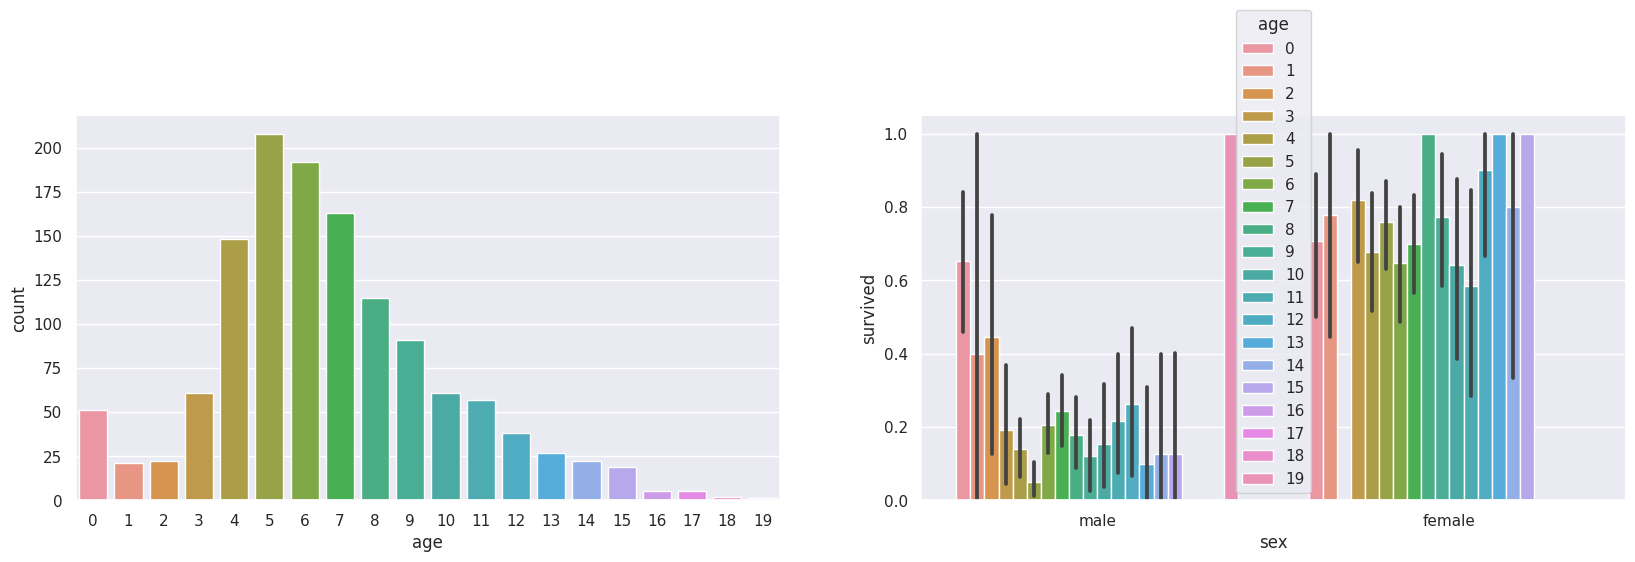

In [26]:
# посмотрим на выживаемость по возрастным группам с разбивкой по полу
# обновим all_data
all_data=pd.concat([train_data,test_data], ignore_index=True)
fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.countplot(ax=axes[0], data=all_data,x='age')
sns.barplot(ax=axes[1], data=all_data, x='sex', y='survived', hue="age")

In [27]:
# меняем male на 1 а female на 2
def map_sex(value):
    if value == 'male':
        return 0
    elif value == 'female':
        return 1
    else:
        return value

for dataset in [train_data, test_data]:
    dataset['sex'] = dataset['sex'].apply(map_sex)
    display(dataset['sex'].unique())

array([0, 1])

array([0, 1])

In [28]:
# меняет аналогично пункты отбытия
def map_embarked(value):
    if value == 'S':
        return 0
    elif value == 'C':
        return 1
    else:
        return 2

for dataset in [train_data, test_data]:
    dataset['embarked'] = dataset['embarked'].apply(map_embarked)
    dataset['embarked'].unique()
    display(dataset['embarked'].unique())

array([0, 1, 2])

array([2, 0, 1])

In [29]:
#обработаем обращения к пассажирам
for dataset in [train_data, test_data]:
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.')

# посмотрим что есть в двух базах
all_data['title'] = all_data.name.str.extract(' ([A-Za-z]+)\.')
all_data['title'].unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

1) 'Mr': Мужчины
2) 'Mrs': Замужние женщины
3) 'Miss': Незамужние женщины или девочки
4) 'Master': Мальчики
5) 'Don', 'Sir', 'Major', 'Col', 'Capt', 'Jonkheer': Обычно обозначают мужчин, часто с определенным социальным статусом или воинским званием
6) 'Rev', 'Dr': Обычно обозначают мужчин с религиозным или академическим званием, хотя эти титулы могут быть присвоены и женщинам
7) 'Mme', 'Ms', 'Lady', 'Countess': Обычно обозначают женщин, часто с определенным социальным статусом
8) 'Mlle': Незамужние женщины во французском (аналог 'Miss')

Сделаем такие категории:
1) Mr, Don, Sir, Major, Col, Capt, Jonkheer
2) Mrs
3) Miss, Mlle, Master
4) Rev, Dr
5) Mme, Ms, Lady, Countess

In [30]:
# Замена титулов на более общие категории
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].replace(['Don', 'Sir', 'Major', 'Col', 'Capt', 'Jonkheer', 'Mr'], 'Mr')
    dataset['title'] = dataset['title'].replace(['Mlle', 'Miss'], 'Miss')
    dataset['title'] = dataset['title'].replace(['Mme', 'Ms', 'Lady', 'Countess', 'Mrs'], 'Mrs')
    dataset['title'] = dataset['title'].replace(['Rev', 'Dr'], 'Clergy/academic')
    dataset['title'] = dataset['title'].replace('Master', 'Master')

# посмотрим распределения выживаемости по группам
print(train_data[['title', 'survived']].groupby(['title'], as_index=False).mean())

# Преобразование титулов в числовые значения
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Clergy/academic": 4}
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].map(title_mapping)
    dataset['title'] = dataset['title'].fillna(0)

             title  survived
0  Clergy/academic  0.230769
1           Master  0.575000
2             Miss  0.701087
3               Mr  0.160000
4              Mrs  0.798450


In [31]:
# есть несколько столбоц которые можно объединить в одну категорию - семья, выделить одиноких и удалить столбец cabine
for dataset in [train_data, test_data]:
    # создаем новый столбец 'family', объединяя 'sibsp' и 'parch'
    dataset['family'] = dataset['sibsp'] + dataset['parch']

    # создаем новый столбец 'is_alone', указывающий, является ли человек одиноким
    dataset['is_alone'] = dataset['family'] == 0

    # удаляем столбец 'cabin' из-за большого количества пропущенных значений
    dataset.drop(['cabin'], axis=1, inplace=True)

In [32]:
# посмотрим на финальны данные. есть пропуски в ageband, это вспомогательный столбец и он нам больше не нужен, не придаем ему далее значения
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   passengerid   891 non-null    int64   
 1   survived      891 non-null    int64   
 2   pclass        891 non-null    int64   
 3   name          891 non-null    object  
 4   sex           891 non-null    int64   
 5   age           891 non-null    int64   
 6   sibsp         891 non-null    int64   
 7   parch         891 non-null    int64   
 8   ticket        891 non-null    object  
 9   fare          891 non-null    float64 
 10  embarked      891 non-null    int64   
 11  digit_ticket  891 non-null    float64 
 12  fareband      891 non-null    category
 13  ageband       714 non-null    category
 14  title         891 non-null    int64   
 15  family        891 non-null    int64   
 16  is_alone      891 non-null    bool    
dtypes: bool(1), category(2), float64(2), int64(10), object

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   passengerid   418 non-null    int64   
 1   pclass        418 non-null    int64   
 2   name          418 non-null    object  
 3   sex           418 non-null    int64   
 4   age           418 non-null    int64   
 5   sibsp         418 non-null    int64   
 6   parch         418 non-null    int64   
 7   ticket        418 non-null    object  
 8   fare          418 non-null    float64 
 9   embarked      418 non-null    int64   
 10  digit_ticket  418 non-null    float64 
 11  fareband      418 non-null    category
 12  ageband       335 non-null    category
 13  title         418 non-null    float64 
 14  family        418 non-null    int64   
 15  is_alone      418 non-null    bool    
dtypes: bool(1), category(2), float64(3), int64(8), object(2)
memory usage: 45.5+ KB


None

In [33]:
# Определяем столбцы для удаления, которые нам не пригодятся в обучении моделей
train_drop = ['name', 'sibsp', 'parch', 'passengerid', 'ageband', 'fareband', 'ticket']
test_drop = ['name', 'sibsp', 'parch', 'ageband', 'fareband', 'ticket']

# Удаляем столбцы
train_data.drop(columns=train_drop, inplace=True)
test_data.drop(columns=test_drop, inplace=True)

In [34]:
# посмотрим на итоговые данные
display(train_data.head())
test_data.head()

,survived,pclass,sex,age,fare,embarked,digit_ticket,title,family,is_alone
0,0,3,0,5,0.0,0,19.0,0,1,False
1,1,1,1,9,2.0,1,6.0,2,1,False
2,1,3,1,6,0.0,0,19.0,1,0,True
3,1,1,1,8,2.0,0,10.0,2,1,False
4,0,3,0,8,0.0,0,18.0,0,0,True


,passengerid,pclass,sex,age,fare,embarked,digit_ticket,title,family,is_alone
0,892,3,0,8,0.0,2,19.0,0.0,0,True
1,893,3,1,11,2.0,0,6.0,2.0,1,False
2,894,2,0,15,0.0,2,19.0,0.0,0,True
3,895,3,0,6,2.0,0,10.0,0.0,0,True
4,896,3,1,5,0.0,0,18.0,2.0,2,False


In [35]:
#переходим к моделям, размерность датасетов должна быть одинаковой
X_train = train_data.drop('survived', axis=1)
y_train = train_data['survived']

X_test = test_data.drop("passengerid", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Создаем объект scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Обучаем scaler на обучающих данных и одновременно трансформируем
X_train = scaler.fit_transform(X_train)
# Трансформируем тестовые данные
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=train_data.columns.drop('survived'))
X_test = pd.DataFrame(X_test, columns=test_data.columns.drop('passengerid'))


In [37]:
# Разделим X_train и y_train на обучающие и тестовые наборы
t_size = 0.1
r_state = 42
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.1, random_state=r_state)

# в словарь будем записывать модель и ее параметры, которые выдают лучшее качество
results = {}

In [38]:
# Логистическая регрессия
if check_all_models == True:
    model = LogisticRegression()
    model.fit(X_train_split, y_train_split)
    y_pred_log_reg = model.predict(X_test_split)
    
    # Вычисление точности
    acc_log_reg = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_log_reg}%")
    results['LogisticRegression'] = {'best_accuracy': acc_log_reg, 'best_params': None}

Accuracy: 81.11%


In [39]:
# Support Vector Machine (SVM)
if check_all_models == True:
    model = SVC()
    model.fit(X_train_split, y_train_split)
    y_pred_svc = model.predict(X_test_split)
    
    # Вычисление точности
    acc_svc = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_svc}%")
    results['SVC'] = {'best_accuracy': acc_svc, 'best_params': None}

Accuracy: 84.44%


In [40]:
# Линейный SVM
if check_all_models == True:
    model = LinearSVC()
    model.fit(X_train_split, y_train_split)
    y_pred_linear_svc = model.predict(X_test_split)
    
    # Вычисление точности
    acc_linear_svc = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_linear_svc}%")
    results['LinearSVC'] = {'best_accuracy': acc_linear_svc, 'best_params': None}

Accuracy: 82.22%


In [41]:
# Решающие деревья
if check_all_models == True:
    model = DecisionTreeClassifier()
    model.fit(X_train_split, y_train_split)
    y_pred_decision_tree = model.predict(X_test_split)
    
    # Вычисление точности
    acc_decision_tree = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_decision_tree}%")
    results['DecisionTreeClassifier'] = {'best_accuracy': acc_decision_tree, 'best_params': None}

Accuracy: 77.78%


In [42]:
# Gaussian Naive Bayes
if check_all_models == True:
    model = GaussianNB()
    model.fit(X_train_split, y_train_split)
    y_pred_gnb = model.predict(X_test_split)
    
    # Вычисление точности
    acc_gnb = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_gnb}%")
    results['GaussianNB'] = {'best_accuracy': acc_gnb, 'best_params': None}

Accuracy: 81.11%


In [43]:
# k-ближайших соседей (KNeighborsClassifier) с подбором лучшего k
if check_all_models == True:
    best_accuracy = 0
    best_k = 0
    
    for k in range(5, 20):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_split, y_train_split)
        acc_knn = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_knn > best_accuracy:
            best_accuracy = acc_knn
            best_k = k
    
    print("Best accuracy is " + str(best_accuracy) + "% with n_neighbors = " + str(best_k))
    results['KNeighborsClassifier'] = {'best_accuracy': best_accuracy, 'best_params': {'n_neighbors': best_k}}

Best accuracy is 84.44% with n_neighbors = 12


In [44]:
# Перцептрон (Perceptron) с подбором лучшего max_iter
if check_all_models == True:
    best_accuracy = 0
    best_iter = 0
    
    for i in range(2, 100):
        model = Perceptron(max_iter=i, tol=None, random_state=r_state)
        model.fit(X_train_split, y_train_split)
        acc_perceptron = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_perceptron > best_accuracy:
            best_accuracy = acc_perceptron
            best_iter = i
    
    print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))
    results['Perceptron'] = {'best_accuracy': best_accuracy, 'best_params': {'max_iter': best_iter, 'tol': None}}

Best accuracy is 87.78% with max_iter = 18


In [45]:
# Стохастический градиентный спуск (SGD) с подбором лучшего max_iter
if check_all_models == True:
    best_accuracy = 0
    best_iter = 0
    
    for i in range(2, 100):
        model = SGDClassifier(max_iter=i, tol=None, random_state=r_state)
        model.fit(X_train_split, y_train_split)
        acc_sgd = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_sgd > best_accuracy:
            best_accuracy = acc_sgd
            best_iter = i
    
    print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))
    results['SGDClassifier'] = {'best_accuracy': best_accuracy, 'best_params': {'max_iter': best_iter, 'tol': None}}

Best accuracy is 84.44% with max_iter = 6


In [46]:
# Случайный лес (RandomForestClassifier) с подбором лучших гиперпараметров
if check_all_models == True:
    best_accuracy = 0
    best_n = 0
    best_max_depth = 0
    
    # Определение гиперпараметров
    param_grid = {
        'n_estimators': range(20, 50),
        'max_depth': range(1, 10)
    }
    
    # Создание модели
    model = RandomForestClassifier(random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_random_forest = best_accuracy
    acc_random_forest = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_random_forest}% with n_estimators = {best_params['n_estimators']}, max_depth = {best_params['max_depth']}")
    results['RandomForestClassifier'] = {'best_accuracy': acc_random_forest, 'best_params': best_params, 'cv':3, 'n_jobs':-1}

Best accuracy is 84.52% with n_estimators = 46, max_depth = 6


In [47]:
# CatBoostClassifier с подбором лучших гиперпараметров
# Определение гиперпараметров
if check_all_models == True:
    param_grid = {
        'iterations': range(1, 16),
        'depth': range(1, 16),
        'learning_rate': np.arange(0.3, 0.5, 0.05)
    }
    
    # Создание модели
    model = CatBoostClassifier(random_seed=r_state, verbose=False)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_catboost = best_accuracy
    acc_catboost = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_catboost}% with iterations = {best_params['iterations']}, depth = {best_params['depth']} and learning_rate = {best_params['learning_rate']}")
    results['CatBoostClassifier'] = {'best_accuracy': acc_catboost, 'best_params': best_params, 'cv':3, 'n_jobs':-1}

Best accuracy is 83.52% with iterations = 11, depth = 6 and learning_rate = 0.44999999999999996


In [48]:
# Gradient Boosting Classifier с подбором лучших гиперпараметров
# Определение гиперпараметров
if check_all_models == True:
    param_grid = {
        'n_estimators': range(15, 20),
        'learning_rate': np.arange(0.3, 0.6, 0.05),
        'max_depth': range(1, 5)
    }
    
    # Создание модели
    model = GradientBoostingClassifier(random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_gbc = best_accuracy
    acc_gbc = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_gbc}% with n_estimators = {best_params['n_estimators']}, learning_rate = {best_params['learning_rate']} and max_depth = {best_params['max_depth']}")
    results['GradientBoostingClassifier'] = {'best_accuracy': acc_gbc, 'best_params': best_params, 'cv':3, 'n_jobs':-1}

Best accuracy is 83.4% with n_estimators = 15, learning_rate = 0.35 and max_depth = 3


In [49]:
# XGBoost с подбором лучших гиперпараметров
if check_all_models == True:
    import xgboost as xgb
        
    # Определение гиперпараметров
    param_grid = {
        'n_estimators': range(15, 20),
        'learning_rate': np.arange(0.5, 0.9, 0.05),
        'max_depth': range(1, 5)
    }
    
    # Создание модели
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_xgb = best_accuracy
    acc_xgb = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_xgb}% with n_estimators = {best_params['n_estimators']}, learning_rate = {best_params['learning_rate']} and max_depth = {best_params['max_depth']}")
    results['XGBClassifier'] = {'best_accuracy': acc_xgb, 'best_params': best_params, 'use_label_encoder': False, 'eval_metric':'mlogloss'}

Best accuracy is 83.9% with n_estimators = 16, learning_rate = 0.7500000000000002 and max_depth = 3


In [50]:
#остортируем результаты и посмотрим на лучшие гиперпараметры
if check_all_models == True:
    sorted_results = sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True)
    for model, info in sorted_results:
        print(f"Model: {model}, Best Accuracy: {info['best_accuracy']} percent, Best Parameters: {info['best_params']}")

Model: Perceptron, Best Accuracy: 87.78 percent, Best Parameters: {'max_iter': 18, 'tol': None}
Model: RandomForestClassifier, Best Accuracy: 84.52 percent, Best Parameters: {'max_depth': 6, 'n_estimators': 46}
Model: SVC, Best Accuracy: 84.44 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 84.44 percent, Best Parameters: {'n_neighbors': 12}
Model: SGDClassifier, Best Accuracy: 84.44 percent, Best Parameters: {'max_iter': 6, 'tol': None}
Model: XGBClassifier, Best Accuracy: 83.9 percent, Best Parameters: {'learning_rate': 0.7500000000000002, 'max_depth': 3, 'n_estimators': 16}
Model: CatBoostClassifier, Best Accuracy: 83.52 percent, Best Parameters: {'depth': 6, 'iterations': 11, 'learning_rate': 0.44999999999999996}
Model: GradientBoostingClassifier, Best Accuracy: 83.4 percent, Best Parameters: {'learning_rate': 0.35, 'max_depth': 3, 'n_estimators': 15}
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LogisticRegression, Best Acc

Perceptron(max_iter=18, random_state=42, tol=None)
Accuracy: 87.78 %


<Axes: >

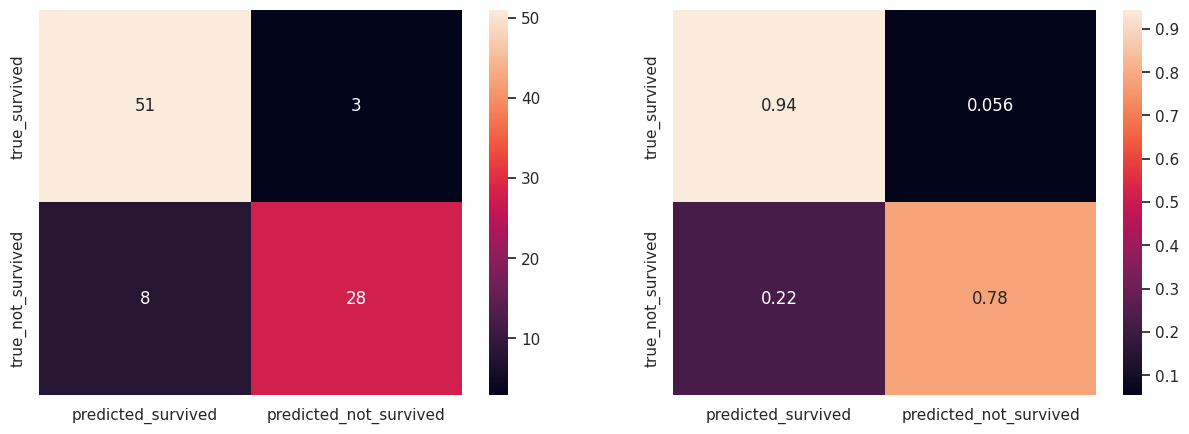

In [51]:
# Словарь, отображающий имя модели на её класс
model_dict = {
    'LogisticRegression': LogisticRegression,
    'SVC': SVC,
    'KNeighborsClassifier': KNeighborsClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'GaussianNB': GaussianNB,
    'Perceptron': Perceptron,
    'SGDClassifier': SGDClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    'CatBoostClassifier': CatBoostClassifier,
    'XGBClassifier': XGBClassifier  # Замените на вашу функцию для создания модели Keras
}

if check_all_models == False:
    model_name = "SGDClassifier"
    best_params = {'max_iter': 93, 'tol': None}
    results = {}
    results[model_name] = {'best_params': best_params, 'best_accuracy': 0.8889}  # Предположим, что лучшая точность составила 90%

# Получение лучшей модели и её параметров
best_model_name, best_model_info = max(results.items(), key=lambda x: x[1]['best_accuracy'])
best_model_class = model_dict[best_model_name]
best_params = best_model_info['best_params']

# Создание экземпляра лучшей модели с лучшими параметрами
if best_params is None:
    model = best_model_class()
else:
    model = best_model_class(**best_params, random_state=r_state)
    print(model)

# Обучение модели и вывод результатов
model.fit(X_train_split, y_train_split)
y_pred = model.predict(X_test_split)
acc = round(model.score(X_test_split, y_test_split) * 100, 2)
print(f"Accuracy: {acc} %")

class_names = ['survived', 'not_survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_split, y_pred)

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

true_class_names = ['true_survived', 'true_not_survived']
predicted_class_names = ['predicted_survived', 'predicted_not_survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)


In [52]:
# Извлечение значений из матрицы ошибок
tp = cnf_matrix[0, 0]  # True positives (правильно предсказано survived)
fn = cnf_matrix[0, 1]  # False negatives (неправильно предсказано not_survived как survived)
fp = cnf_matrix[1, 0]  # False positives (неправильно предсказано survived как not_survived)
tn = cnf_matrix[1, 1]  # True negatives (правильно предсказано not_survived)

# Вычисление относительных значений
total_survived = tp + fn
total_not_survived = fp + tn

accuracy_survived = tp / total_survived
error_survived = fn / total_survived
error_not_survived = fp / total_not_survived
accuracy_not_survived = tn / total_not_survived

# Формирование текста
description = f"""
## На изображении показаны две матрицы ошибок (confusion matrix) для классификации:

### Левая матрица (в абсолютных значениях):
- {tp}: Правильно предсказано survived (истинно положительные).
- {fn}: Неправильно предсказано not_survived как survived (ложные отрицательные).
- {fp}: Неправильно предсказано survived как not_survived (ложные положительные).
- {tn}: Правильно предсказано not_survived (истинно отрицательные).

### Правая матрица (в относительных значениях):
- {accuracy_survived:.2f}: Доля правильных предсказаний survived.
- {error_survived:.3f}: Доля ошибок, когда survived предсказано как not_survived.
- {error_not_survived:.2f}: Доля ошибок, когда not_survived предсказано как survived.
- {accuracy_not_survived:.2f}: Доля правильных предсказаний not_survived.
"""

print(description)


## На изображении показаны две матрицы ошибок (confusion matrix) для классификации:

### Левая матрица (в абсолютных значениях):
- 51: Правильно предсказано survived (истинно положительные).
- 3: Неправильно предсказано not_survived как survived (ложные отрицательные).
- 8: Неправильно предсказано survived как not_survived (ложные положительные).
- 28: Правильно предсказано not_survived (истинно отрицательные).

### Правая матрица (в относительных значениях):
- 0.94: Доля правильных предсказаний survived.
- 0.056: Доля ошибок, когда survived предсказано как not_survived.
- 0.22: Доля ошибок, когда not_survived предсказано как survived.
- 0.78: Доля правильных предсказаний not_survived.



In [53]:
# Подготовка данных
features = X_train.columns.tolist()
X_test = test_data[features]
predictions = model.predict(X_test)

# Сохранение предсказаний в CSV файл
output = pd.DataFrame({'PassengerId': test_data.passengerid, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Далее тесты в зависимости от числа rang_group
## rang_group = 2

Model: DecisionTreeClassifier, Best Accuracy: 85.56 percent, Best Parameters: None
Model: SVC, Best Accuracy: 84.44 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 84.44 percent, Best Parameters: {'n_neighbors': 14}
Model: Perceptron, Best Accuracy: 83.33 percent, Best Parameters: {'max_iter': 20, 'tol': None}
Model: SGDClassifier, Best Accuracy: 83.33 percent, Best Parameters: {'max_iter': 6, 'tol': None}
Model: CatBoostClassifier, Best Accuracy: 83.27 percent, Best Parameters: {'depth': 9, 'iterations': 12, 'learning_rate': 0.39999999999999997}
Model: XGBClassifier, Best Accuracy: 83.15 percent, Best Parameters: {'learning_rate': 0.6000000000000001, 'max_depth': 3, 'n_estimators': 17}
Model: RandomForestClassifier, Best Accuracy: 82.9 percent, Best Parameters: {'max_depth': 5, 'n_estimators': 36}
Model: GradientBoostingClassifier, Best Accuracy: 82.9 percent, Best Parameters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 18}
Model: LogisticRegression, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 82.22 percent, Best Parameters: None

## rang_group = 5
Model: Perceptron, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 69, 'tol': None}
Model: SVC, Best Accuracy: 84.44 percent, Best Parameters: None
Model: SGDClassifier, Best Accuracy: 84.44 percent, Best Parameters: {'max_iter': 63, 'tol': None}
Model: RandomForestClassifier, Best Accuracy: 83.9 percent, Best Parameters: {'max_depth': 5, 'n_estimators': 34}
Model: XGBClassifier, Best Accuracy: 83.9 percent, Best Parameters: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 16}
Model: GradientBoostingClassifier, Best Accuracy: 83.77 percent, Best Parameters: {'learning_rate': 0.49999999999999994, 'max_depth': 3, 'n_estimators': 19}
Model: CatBoostClassifier, Best Accuracy: 83.52 percent, Best Parameters: {'depth': 12, 'iterations': 15, 'learning_rate': 0.44999999999999996}
Model: GaussianNB, Best Accuracy: 83.33 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 82.22 percent, Best Parameters: {'n_neighbors': 6}
Model: LogisticRegression, Best Accuracy: 81.11 percent, Best Parameters: None
Model: DecisionTreeClassifier, Best Accuracy: 77.78 percent, Best Parameters: None

## rang_group = 10
Model: Perceptron, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 12, 'tol': None}
Model: SGDClassifier, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 18, 'tol': None}
Model: CatBoostClassifier, Best Accuracy: 83.4 percent, Best Parameters: {'depth': 7, 'iterations': 13, 'learning_rate': 0.35}
Model: GradientBoostingClassifier, Best Accuracy: 83.4 percent, Best Parameters: {'learning_rate': 0.49999999999999994, 'max_depth': 2, 'n_estimators': 19}
Model: SVC, Best Accuracy: 83.33 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 83.33 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 83.33 percent, Best Parameters: {'n_neighbors': 5}
Model: XGBClassifier, Best Accuracy: 83.15 percent, Best Parameters: {'learning_rate': 0.6000000000000001, 'max_depth': 2, 'n_estimators': 15}
Model: RandomForestClassifier, Best Accuracy: 82.9 percent, Best Parameters: {'max_depth': 4, 'n_estimators': 33}
Model: LogisticRegression, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: DecisionTreeClassifier, Best Accuracy: 77.78 percent, Best Parameters: None

## rang_group = 15

Model: Perceptron, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 19, 'tol': None}
Model: SGDClassifier, Best Accuracy: 84.44 percent, Best Parameters: {'max_iter': 81, 'tol': None}
Model: RandomForestClassifier, Best Accuracy: 83.4 percent, Best Parameters: {'max_depth': 7, 'n_estimators': 33}
Model: SVC, Best Accuracy: 83.33 percent, Best Parameters: None
Model: CatBoostClassifier, Best Accuracy: 83.27 percent, Best Parameters: {'depth': 7, 'iterations': 15, 'learning_rate': 0.35}
Model: XGBClassifier, Best Accuracy: 82.77 percent, Best Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 16}
Model: GradientBoostingClassifier, Best Accuracy: 82.65 percent, Best Parameters: {'learning_rate': 0.49999999999999994, 'max_depth': 1, 'n_estimators': 15}
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LogisticRegression, Best Accuracy: 81.11 percent, Best Parameters: None
Model: DecisionTreeClassifier, Best Accuracy: 77.78 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 77.78 percent, Best Parameters: {'n_neighbors': 8}

## rang_group = 20
Model: SGDClassifier, Best Accuracy: 87.78 percent, Best Parameters: {'max_iter': 93, 'tol': None}
Model: Perceptron, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 3, 'tol': None}
Model: RandomForestClassifier, Best Accuracy: 84.02 percent, Best Parameters: {'max_depth': 5, 'n_estimators': 20}
Model: CatBoostClassifier, Best Accuracy: 83.65 percent, Best Parameters: {'depth': 6, 'iterations': 13, 'learning_rate': 0.44999999999999996}
Model: SVC, Best Accuracy: 83.33 percent, Best Parameters: None
Model: GradientBoostingClassifier, Best Accuracy: 83.27 percent, Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 17}
Model: XGBClassifier, Best Accuracy: 83.15 percent, Best Parameters: {'learning_rate': 0.55, 'max_depth': 2, 'n_estimators': 16}
Model: LogisticRegression, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 82.22 percent, Best Parameters: None
Model: DecisionTreeClassifier, Best Accuracy: 77.78 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 77.78 percent, Best Parameters: {'n_neighbors': 12}

## rang_group = 30
Model: SGDClassifier, Best Accuracy: 86.67 percent, Best Parameters: {'max_iter': 79, 'tol': None}
Model: Perceptron, Best Accuracy: 84.44 percent, Best Parameters: {'max_iter': 36, 'tol': None}
Model: CatBoostClassifier, Best Accuracy: 83.65 percent, Best Parameters: {'depth': 7, 'iterations': 12, 'learning_rate': 0.44999999999999996}
Model: GradientBoostingClassifier, Best Accuracy: 83.15 percent, Best Parameters: {'learning_rate': 0.5499999999999999, 'max_depth': 2, 'n_estimators': 15}
Model: RandomForestClassifier, Best Accuracy: 82.9 percent, Best Parameters: {'max_depth': 3, 'n_estimators': 21}
Model: XGBClassifier, Best Accuracy: 82.9 percent, Best Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 16}
Model: LogisticRegression, Best Accuracy: 82.22 percent, Best Parameters: None
Model: SVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 81.11 percent, Best Parameters: None
Model: DecisionTreeClassifier, Best Accuracy: 78.89 percent, Best Parameters: None
Model: KNeighborsClassifier, Best Accuracy: 76.67 percent, Best Parameters: {'n_neighbors': 18}

# Итоги
rang_group = 20 показал наилучший результат, может быть потом еще поищу, как сделать лучше, но это неточно :)